# Get the data

## Downloading the data

Download the housing data in the form of CSV

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Call fetch_housing_data() and fetches the newest data in github. It creates a *datasets/housing* directory in the workspace and downloads the *housing.tgz* file and extracts it. *housing.csv* is created in the directory.

In [3]:
fetch_housing_data()

Load the data using Pandas. This function returns a Pandas Dataframe object that contains all the data.

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Take a quick look at the Data Structure

Take a look at the top five rows.

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Get a quick description of the data, in particular the total number of rows, and each attribute's type and non-null values.

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Need to notice the following two things:
1. The attribute *total_bedrooms* has 20433 non-null float64, which means that 207 districts are missing this feature. We need to tale care of this later.
2. The type of attribute *ocean_proximity* is object. It is obvious that it is a categorical attribute.

Using the value_counts() method to find out what categories exist and how many districts belong to each category.

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Using describe() method to show a summary of the numerical attributes.

In [8]:
housing.describe()

C:\Users\13129\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,NaN,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,NaN,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,NaN,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Using the histogram to show each numerical attribute.

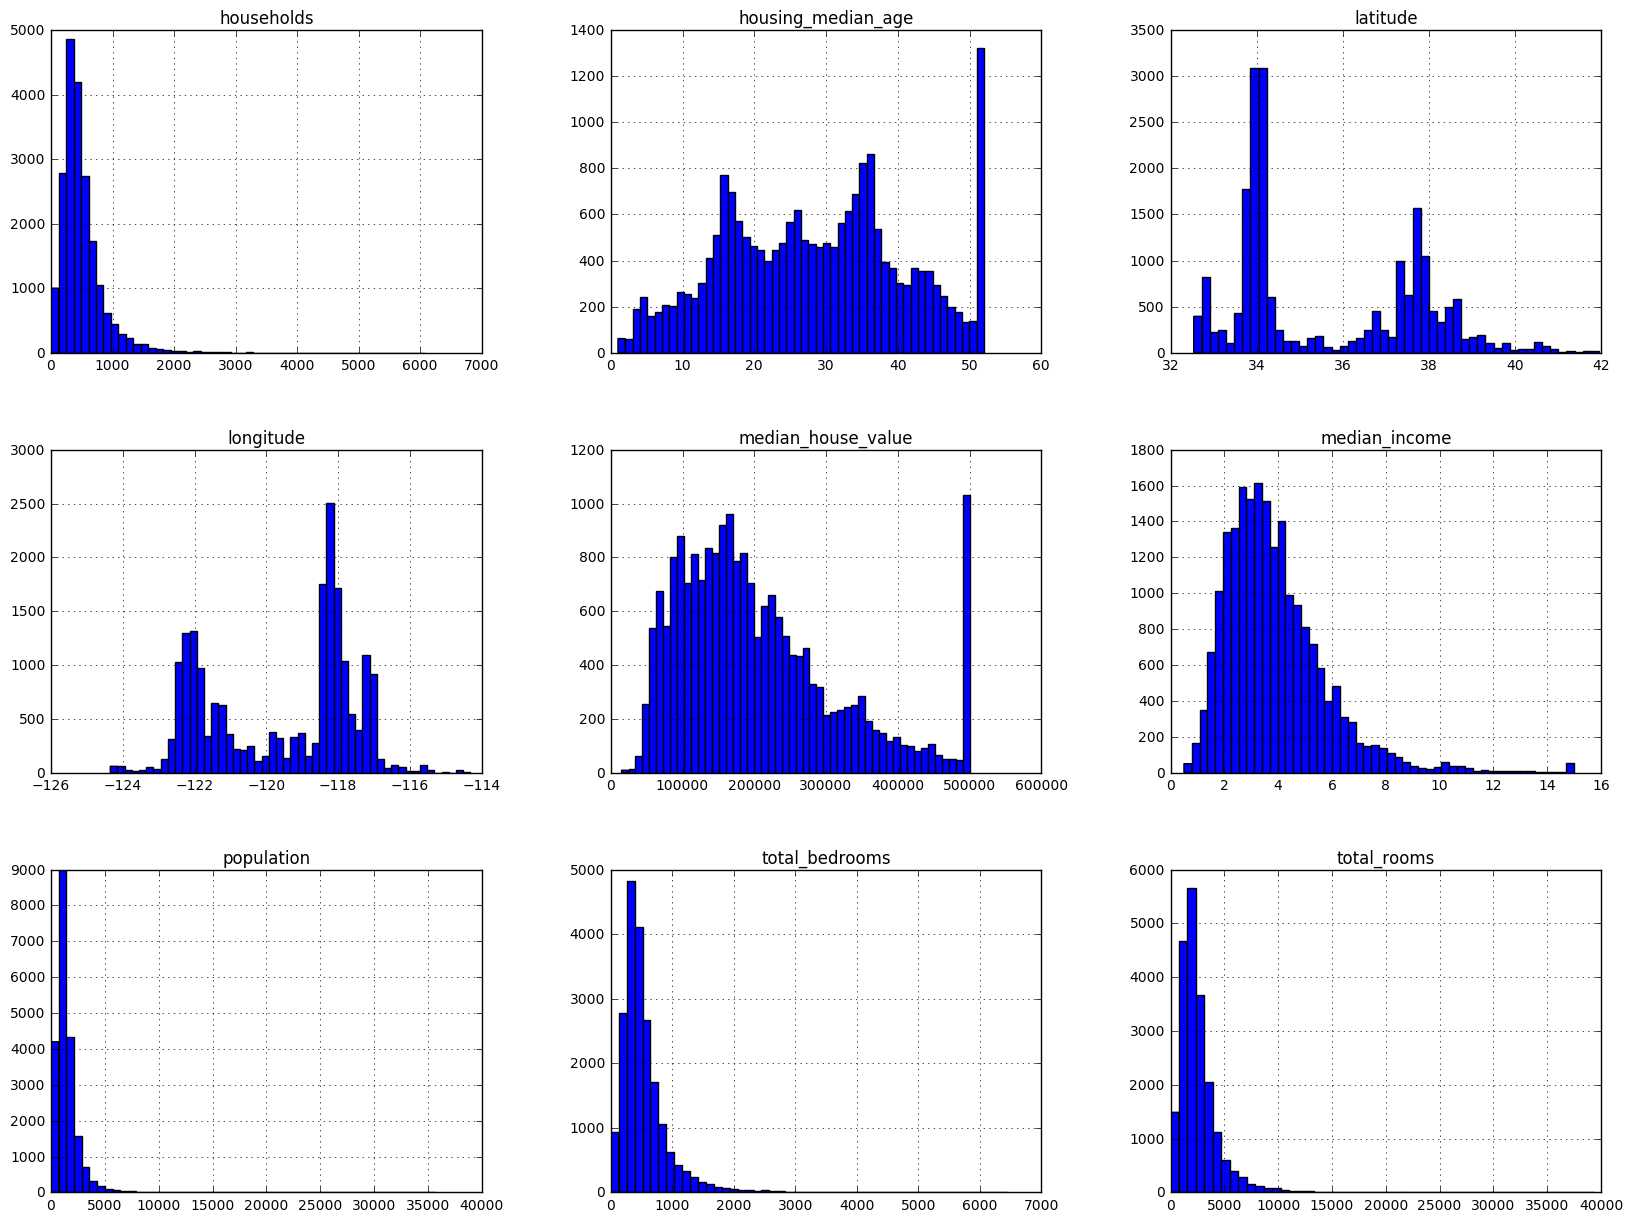

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Problems shown in the histogram:
1. In the field of *median_income*, the data has been scaled and capped at 15 for higher median incomes and at 0.5 for lower median incomes. It is not nessarily a problem, but should try to be understood how the data was computed.
2. The *housing_median_age* and the *median_housing_value* are also capped. The latter is a problem because it is the target label. Solutions can be:
   + Collect proper labels for the labels for the district whose labels were capped.
   - Remove those capped districts because if we do not remove them, our model will find that prices never go beyond that capped limit.
3. These attributes have very different scales.
4. Many histograms are tail heavy. We will try transforming these attributes later on to have more bell-shaped distributions.

## Create a Test Set

Create a test set is simple: just pick the given ratio of data out of the original data.

In [10]:
import numpy as np

def split_train_set(data, test_ratio):
    shuffled_indice = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indice = shuffled_indice[:test_set_size]
    train_indice = shuffled_indice[test_set_size:]
    return data.iloc[train_indice], data.iloc[test_indice]

In [11]:
train_set, test_set = split_train_set(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


It works! But, the problem is that each time we run the *split_train_set()*, we will get different train set and test set. After many times of running, we will get the whole data set, which is what we try to avoid.
One solution is to compute the hash of each instance's identifier and keep only the last byte of hash and put the instance in the test set if the value is lower or equal to 51 (20% of 256)

Here is implementation:

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda _id: test_set_check(_id, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Since the housing data does not have identifier, so the simplest way is to use row index as ID:

In [13]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Another way is to use a more stable sttribute as identifier, which is to use latitude and longitude.

In [14]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

SK-learn provides functions to split datasets. The simplest one is *train_test_split*, which does pretty much the same thing as the function *split_train_test* that defines before.
+ There is a *random_state* that allows you to set the random generator seed.
- It can be passed multiple datasets with an identical number of rows and it will split them on the same indices.

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Using stratified sampling to sample the training set and test set.

In [16]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Using Scikit-Learn's *StratifiedShuffleSplit* class to do straified sampling based on income category.

*StratifiedShuffleSplit.splir(X,y)* means that it uses the value of y to stratify X.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Remove the *income_cat* attribute so the data is back to its original state:

In [18]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

+ Make sure that you have put the test set aside and you are only exploring the training set.
- If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast.

## Visualizing Geographical Data

Create a scatterplot of all districts to visualize the data.

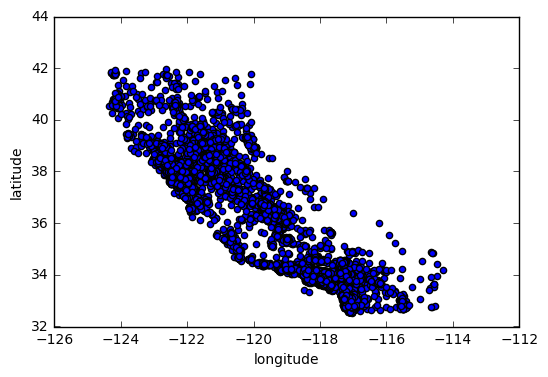

In [19]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the *alpha* option to 0.1 makes it much easier to visualize the places where is a high density of data points.

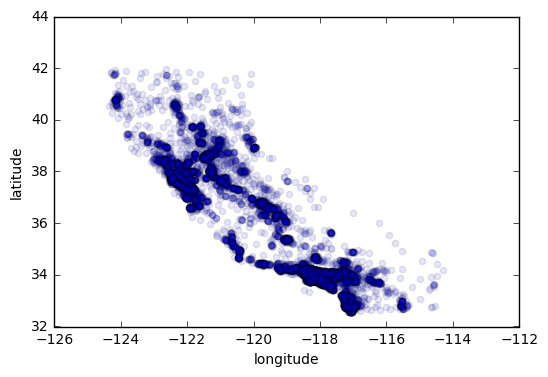

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Play around with visualization parameters to make the patterns stand out.

The radius of each circle represents the district's population (option *s*), and the color represents the price (option *c*). We will use a predefined color map (option *cmap*) called *jet*, which ranges from blue (low values) to red (high prices)

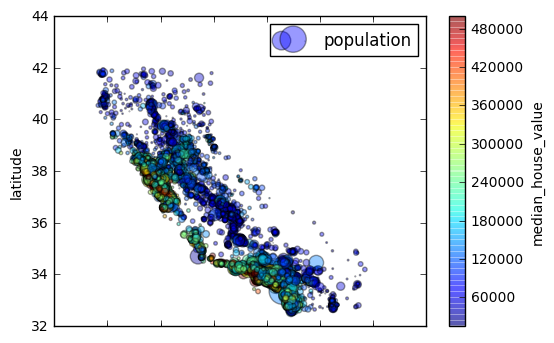

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

## Looking for Correlations

We can calculate the *Pearson's standard correlation coefficient* between every pair of attributes using the *corr()* method

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from -1 to 1:
+ When it is close to 1, it means that there is a strong positive correlation.
- When it is close to -1. it means that there is a strong negative correlation.
+ When it is zero, it means that there is no linear correlation.

Notice following points about the correlation coefficient:
+ The correlation coefficient only measures linear correlations. It may completely miss out on nonlinear relationships.
- The correlation coefficient has nothing to do with the slope.

Another way to check for corrlation between attributes is to use Pandas' *scatter_matrix* function, which plots every numerical sttributes against every other numberical attribute.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDF9DA5588>,
      dtype=object)

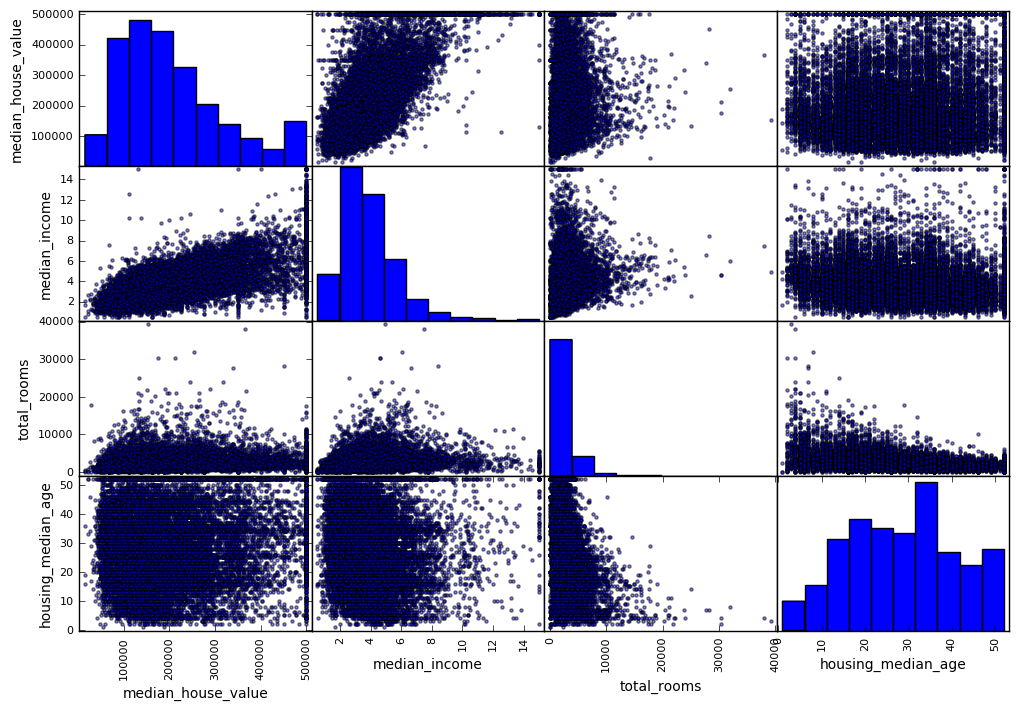

In [23]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The most promising attribute to predict the median house value is the median income, so we will zoom in on their correlation scatterplot.

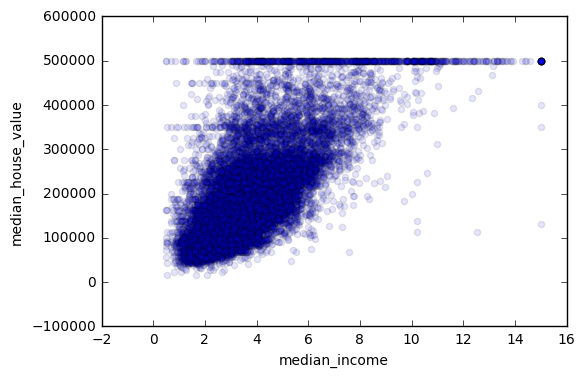

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveal following things:
+ The correlation is indeed very strong.
- The price cap of 500000 exists. There are some horizontal lines below 500000.

## Experimenting with Attribute Combinations

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations.

In [25]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_houshold"] = housing["population"] / housing["households"]

Look at the correlation matrix again:

In [26]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value         1.000000
median_income              0.687160
rooms_per_household        0.146285
total_rooms                0.135097
housing_median_age         0.114110
households                 0.064506
total_bedrooms             0.047689
population_per_houshold   -0.021985
population                -0.026920
longitude                 -0.047432
latitude                  -0.142724
bedrooms_per_room         -0.259984
Name: median_house_value, dtype: float64

We can get a not bad conclusion through this try out:
+ Houses with a lower bedroom/room ratio tend to be more expensive(*bedrooms_per_room*)
- The number of rooms per household is also more informative than the total number of rooms in a district(*rooms_per_household*)

# Prepare the Data for Machine Learning Algorithms

Separate the predictors and the labels first.

In [28]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

To deal with the missing features in *total_bedrooms*, there are three options to fix it:
- Get rid of the corresponding districts.
+ Get rid of the whole attribute.
- Set the values to some value (zero, the mean, the median...)

In [30]:
housing.dropna(subset=["total_bedrooms"])   #option 1
housing.drop("total_bedrooms", axis=1)   #option 2
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)   #option 3

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, dt

Scikit-Learn provides a handy class to take care of missing values: *Imputer*. The usage of *Imputer* will be discussed below:
1. You need to create an *Imputer* instance, specifying that you want to replace each attribute's missing values with the median of that value.
2. Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute.
3. Fit the *imputer* instance to training data using the *fit()* method
4. Use the "trained" *imputer* to transform the training set by replacing the missing values by the learned medians.
5. The result is a plain Numpy array containing the transformed features. It is necessary to put it back into a Pandas Dataframe.

In [33]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

The *imputer* has simply computed the median of each attribute and stored the result in its *statistics_* instance variable.

In [35]:
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


## Handling Text and Categotical Attributes

Since most machine learning algorithms prefer to work with numbers, it is necessary to convert text labels to numbers.
Scikit-Learn provides a transformer for this task called *LabelEncoder*

In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)

[0 0 4 ... 1 0 3]


You can look at the mapping that this encoder has learned using che *classes_* attribute:

In [38]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


One issue with this representation is that ML algorithm will assume that two nearby values are more similar than two distant values.

To fix this issue, a common solution is to create one binery attribute per category. This is called *one-hot encoding*, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

Scikit-Learn provides a *OneHotEncoder* encoder to convert integer categorical values into one-hot vectors. Note that *fit_transform()* expects a 2D array, but *housing_cat_encoded* is an 1D array, which needs to be reshaped.

In [41]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a Scipy *sparse matrix*, instead of a NumPy array. After one-hot encoding, we have got a matrix with many columns, and the matrix is full of zero except for one 1 per row. Using up to tons of memory mostly to store zeros would be very wasteful, so the *sparse matrix* only stores the locations of nonzero elements. It can be used like a 2D array, but if you really want to convert it to a Numpy array, just call *toarray()* method.

In [42]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

We can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using *LabelBinarizer* class. Note that this returns a Numpy array by default. We can get a sparse matrix instead by passing *sparse_output=True* to the *LabelBinarizer* constructor.

In [46]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom transformers

You should make your transformer work seamlessly with Scikit-Learn functionalities, and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class anf implement three methods: *fit()* (return *self*), *transform()* , and *fit_transform()*.

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_houshold = X[:, population_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, household_ix]
            return np.c_[X, rooms_per_houshold, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_houshold, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling

With few exceptions, Machine Learning algorithms don't perform well when the input numerical attributes have very different scales. There are two common ways to get all attributes to have the same scale: *min-max scaling* and *standardization*.

Min-max scaling (many people call this *normalization*) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. Scikit-Learn provides a transformer called *MinMaxScaler* for this. It has a *feature_range* hyperparameter that lets you change the range if you don't want 0-1 for some reason.

Standardization is quite different: first it substracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Standardization is much less affected by outliers. Scikit-Learn provides a transformer called *StandardScaler* for standardization.

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set).

## Transformation Pipelines

Scikit-Learn provided the *Pipeline* class to help with such sequence of transformations.

All but the last estimator must be transformers (i.e., they must hace a *fit_transform()* method).

When you call the pipeline's *fit()* method, it calls *fit_transform()* sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the *fit()* method.

The pipeline exposes the same methods as the final estimator.

Here is a small pipeline for the numerical attributes.

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

To accomplish a full pipeline, we need a selector to select numerical attributes from categorical attributes. It tramsforms the data by selecting the disired attributes, dropping the rest, and converting the resulting DataFrame to a NumPy array.

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now we have a pipeline for numerical attributes, but we also need to apply the *LabelBinarizer* on categorical values.

Scikit-Learn provides a *FeatureUnion* class for this. You give it a list of transformers, which can be entire transformer pipelines, and when its *transform()* method is called, it runs each transformer's *transform()* method in parallel, waits for their output, and then concatenates them and returns the result.

In [64]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])

Now, we can run the whole pipeline simply:

In [65]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [66]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

First, train a Linear Regression model.

In [67]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Try the linear regression model out on a few instances from the training set:

In [69]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [211758.04876224 320701.474177   211169.34620852  61484.61823939
 193391.95676363]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Let's measure the regression model's RMSE(均方根方差) on the whole training set using Scikit-Learn's *mean_squared_error* function

In [70]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68945.31723157618

This is an example of a model underfitting the training data. When this happens, it can mean that the features do not provide encough information to make good predictions, or that the model is not powerful enough.

The main ways to fix underfitting are to:
+ select a more powerful model
- feed the training algorithm with better features
+ reduce the constrains on the model

Let's first try a more complex model to see how it does. Let's train a *DecisionTreeRegressor*.

In [71]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

Now, thw model is trained, let's evaluate it on the training set:

In [73]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It is much likely that the model has badly overfit the data. We need to use part of the training set for the training, and part for model validation.

## Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the *train_test_split* function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set.

An alternative is to use Scikit-Learn's *cross-validation* feature. The following performs a *K-fold cross-validation*:

In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores [71701.33006414 69305.75941474 71712.5306679  71170.42089559
 72280.82211648 75023.14577421 74051.13120179 69380.37370382
 72525.32995585 71892.92528417]
Mean: 71904.37690786915
Standard deviation: 1691.2370484594394


*K-fold cross-validation* randomly splits the training set into 10 distinct subsets called *folds*, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing 10 evaluation scores.

Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE.

Now the decision Tree doesn't look as good as it did earlier. Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation).

Let's compute the same scores for the Linear Regression model.

In [76]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores [67350.68522179 67267.91060695 69033.96427924 74763.93104939
 68279.64746497 71573.17772942 65216.69652734 68565.70673261
 72484.5727776  68056.05096523]
Mean: 69259.2343354534
Standard deviation: 2700.885737007772


The result is that the Decision Tree Model is overfitting so badly that it performs worse than the Linear Regression Model.

We will try one last model: the *RandomForestRegressor*. Random Forest works by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called *Ensemble Learning(集成学习)*, and it is often a great way to push ML algorithm even further.

In [78]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions_forest = forest_reg.predict(housing_prepared)
print(np.sqrt(mean_squared_error(housing_predictions_forest, housing_labels)))
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

22863.81807861684
Scores [53084.01838958 51836.4859456  53494.50032625 55579.96020414
 51499.8295282  55677.7320919  51954.53775077 51119.02302149
 56439.94666621 53611.59313375]
Mean: 53429.76270578774
Standard deviation: 1807.5866500849538


Random Forests look very promising. However, note that the score on the training set is still lower than on the validation set. Possible solutions for ovrfitting are to simplity the model, constrain it (i.e., regularize it), or get a lot more training data.

# Fine-Tune Your Model

Assume that you have a shortlist of promising models and you need to fine-tune them.

## Grid Search

One way to do that would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values.

Scikit-Learn provides *GridSearchCV* to search for you. All you need to do is to tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparamete values using cross-validation

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid,cv=5,
                          scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

This *param_grid* tells scikit-Learn to first evaluate all combinations of *n_estimators* and *max_features* hyperparameter values specified in the dict.

We can get the best combination of parameters like this:

In [80]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

You can get the best estimator directly:

In [81]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

The evaluation scores are also available:

In [82]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

67326.55347016135 {'max_features': 2, 'n_estimators': 3}
57196.61104815361 {'max_features': 2, 'n_estimators': 10}
53440.257969542436 {'max_features': 2, 'n_estimators': 30}
60947.04733052899 {'max_features': 4, 'n_estimators': 3}
53660.600245898786 {'max_features': 4, 'n_estimators': 10}
50855.53972954605 {'max_features': 4, 'n_estimators': 30}
59212.254986149754 {'max_features': 6, 'n_estimators': 3}
52724.59487875074 {'max_features': 6, 'n_estimators': 10}
50412.79041209012 {'max_features': 6, 'n_estimators': 30}
59413.88128172455 {'max_features': 8, 'n_estimators': 3}
52108.755450108685 {'max_features': 8, 'n_estimators': 10}
50583.70496313746 {'max_features': 8, 'n_estimators': 30}
64260.598375319765 {'bootstrap': False, 'n_estimators': 3, 'max_features': 2}
55238.05522896163 {'bootstrap': False, 'n_estimators': 10, 'max_features': 2}
61257.51133005979 {'bootstrap': False, 'n_estimators': 3, 'max_features': 3}
53506.818138064606 {'bootstrap': False, 'n_estimators': 10, 'max_featur

## Randomized Search

When the hyperparameter *search space* is large, it is oftem perferable to use *RandomizedSearchCV* instead.

This class can be used in much the same way as the *GridSearchCV* class, but instead of trying out all possible combinations, it evaluates a given number of random conbinations by selecting a random value for each hyperparameter at every iteration.

## Ensenble Methods

Another way to fine-tune your system is to tey to combine the models that perform best. The group will often perform better than the best individual model, especially if the individual models make very differnet types of errors.

## Analyze the Best Models and Their Errors

By inspecting the best models, we can get the relative importance of each attribute for making accurate prredictions. We will display these importance scores next to their corresponding attribute names.

In [85]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold","bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3918463986635109, 'median_income'),
 (0.13775932826208595, 'INLAND'),
 (0.08885773769696378, 'longitude'),
 (0.08431857937094554, 'latitude'),
 (0.07114001433457667, 'rooms_per_hhold'),
 (0.061425669439442984, 'pop_per_hhold'),
 (0.04125051527188069, 'housing_median_age'),
 (0.02394969036796949, 'bedrooms_per_room'),
 (0.021311568734583335, 'total_rooms'),
 (0.018031744734532736, 'total_bedrooms'),
 (0.017632527299796915, 'households'),
 (0.017081273741433787, 'population'),
 (0.01652712750439137, '<1H OCEAN'),
 (0.006224901111190866, 'NEAR OCEAN'),
 (0.002568216057289974, 'NEAR BAY'),
 (7.470740940502528e-05, 'ISLAND')]

With this information. we can drop some of the less useful features.

## Evaluate Your System on the Test Set

There is nothing special about this process: just get the predictors and the labels from the test set, run the *full_pipeline* to transform the data (call *transform()*, not *fit_transform()*), and evaluate the final model on the test set.

In [89]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48540.14511303556


Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system's limitations are), document everything, and create nice presentations with clear visulizations and easy-to-remember statements (e.g., "the median income is the number one predictor of the housing prices").

# Exercises

In [90]:
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

SV_reg = SVR()
grid_search = GridSearchCV(SV_reg, param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)


KeyboardInterrupt: 

In [ ]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)